### **Mount Google Drive**

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ***Importing Data Modelling Libaries***

In [21]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")
import unicodedata
import itertools
import collections
import re
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk import bigrams, trigrams
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

from bs4 import BeautifulSoup
from pprint import pprint
import urllib
from urllib.request import urlopen

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Reading Datasets**

In [0]:
#  Read training and test data from CSV file
train_data = pd.read_csv('/content/drive/My Drive/Sentiment Analysis hackathon/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/Sentiment Analysis hackathon/test.csv')

In [23]:
#  Shape of Training and Test data
print(f"Shape of training dataset:{train_data.shape}")
print(f"Shape of test dataset:{test_data.shape}")

Shape of training dataset:(7274, 3)
Shape of test dataset:(1819, 2)


In [24]:
# look into training and test data
print(f"Training dataset")
train_data.head()

Training dataset


,tweet_id,tweet,sentiment
0,1701,#sxswnui #sxsw #apple defining language of tou...,1
1,1851,Learning ab Google doodles! All doodles should...,1
2,2689,one of the most in-your-face ex. of stealing t...,2
3,4525,This iPhone #SXSW app would b pretty awesome i...,0
4,3604,Line outside the Apple store in Austin waiting...,1


In [25]:
print(f"Test dataset")
test_data.head()

Test dataset


,tweet_id,tweet
0,7506,Audience Q: What prototyping tools do you use?...
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...
2,247,@mention and here's a pic of you winning your...
3,7688,Google Marissa Mayer: mobile phone as a cursor...
4,3294,#SXSW Google maps is even cooler than I thought


### **Exploratory Data Analysis**

In [26]:
# Fetching sentiments from training data
# 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell
training_sentiments = dict(train_data['sentiment'].value_counts())
training_sentiments

{0: 456, 1: 4311, 2: 2382, 3: 125}

Text(0.5, 1.0, 'Distribution of Sentiments')

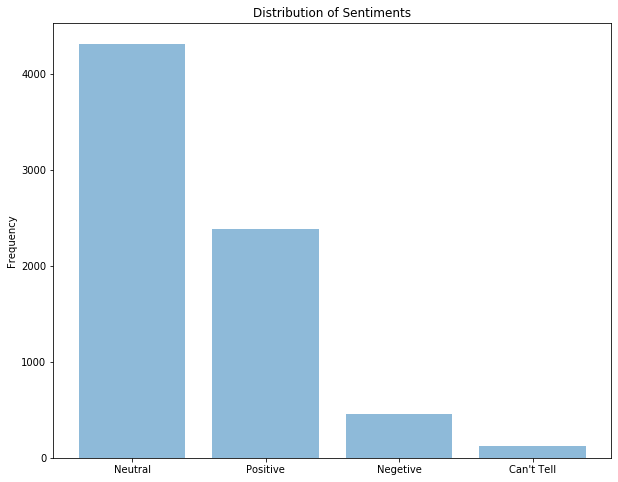

In [27]:
# Plot distribution of sentiments 
objects = ('Neutral', 'Positive', 'Negetive', 'Can\'t Tell')
y_pos = np.arange(len(training_sentiments))
plt.figure(figsize=(10,8))
plt.bar(y_pos, training_sentiments.values(), align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Frequency')
plt.title('Distribution of Sentiments')

In [0]:
#  Create dataframe for tweets of training dataset
tweets = pd.DataFrame(train_data['tweet'],columns =['tweet'])

In [29]:
tweets.shape

(7274, 1)

In [0]:
#  Converting datatype of tweet column as string
tweets['tweet'] = tweets['tweet'].astype(str)

### **Creating WordCloud from Sentiments**


wordcloud for sentiments 0



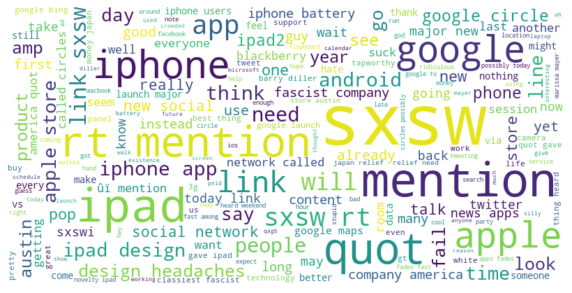


wordcloud for sentiments 1



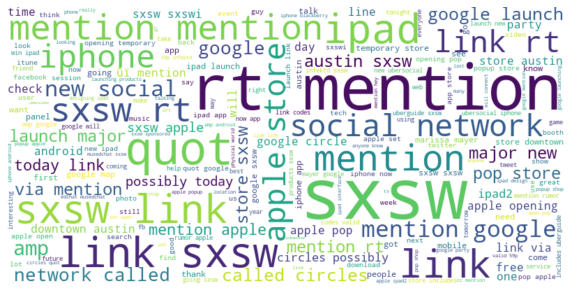


wordcloud for sentiments 2



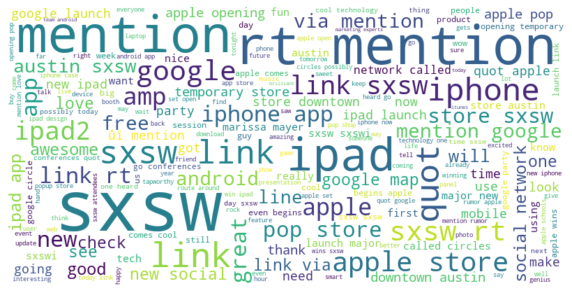


wordcloud for sentiments 3



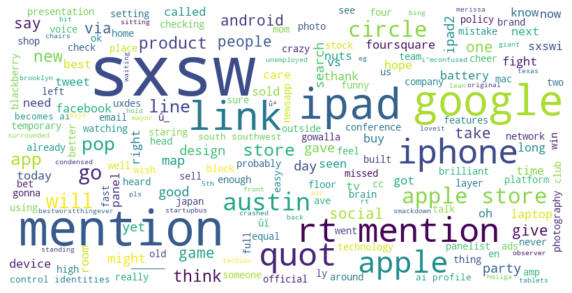

In [31]:
#  Creating wordcloud for sentiments
def create_wordcloud(sentiments):
  wordcloud = WordCloud(background_color='white',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)
  
  for i in range(len(sentiments)):
    print()
    print("wordcloud for sentiments", i)
    print()

    wordcloud.generate(sentiments[i])
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

sentiment_neutral  = ' '.join([str(text).lower() for text in train_data.loc[train_data['sentiment'] == 1, 'tweet']])
sentiment_positive = ' '.join([str(text).lower() for text in train_data.loc[train_data['sentiment'] == 2, 'tweet']])
sentiment_negative = ' '.join([str(text).lower() for text in train_data.loc[train_data['sentiment'] == 0, 'tweet']])
sentiment_unknown  = ' '.join([str(text).lower() for text in train_data.loc[train_data['sentiment'] == 3, 'tweet']])
sentiments = [sentiment_negative, sentiment_neutral, sentiment_positive, sentiment_unknown]
create_wordcloud(sentiments)

### **Finding ReTweets**

In [32]:
#  Find ReTweets
tweets['is_retweet'] = tweets['tweet'].astype(str).apply(lambda x: x[:2]=='RT')
tweets['is_retweet'].sum()

1586

In [33]:
# Finding top most repeated tweets
tweets.groupby(['tweet']).size().reset_index(name = 'counts').sort_values(by = 'counts',ascending=False).head(10)

,tweet,counts
5069,RT @mention Marissa Mayer: Google Will Connect...,5
5068,RT @mention Marissa Mayer: Google Will Connect...,4
4782,RT @mention Google to Launch Major New Social ...,3
3800,Need to buy an iPad2 while I'm in Austin at #s...,2
1669,"Before It Even Begins, Apple Wins #SXSW {link}",2
5692,"RT @mention ÷¼ Happy Woman's Day! Make love, ...",2
5690,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ...,2
3651,Marissa Mayer: Google Will Connect the Digital...,2
4781,RT @mention Google to Launch Major New Social ...,2
6637,Win free ipad 2 from webdoc.com #sxsw RT,2


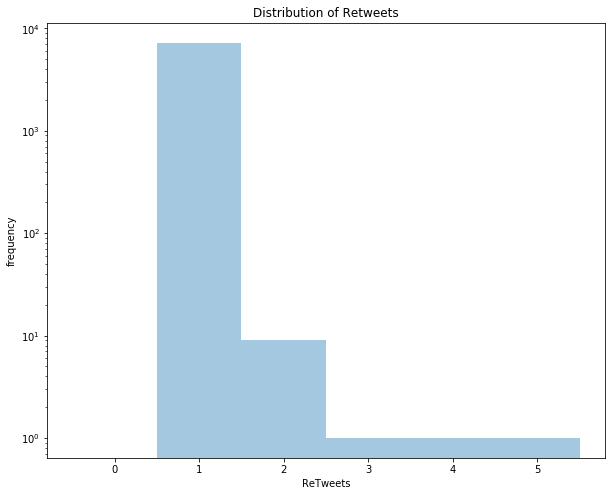

In [34]:
#  Distribution of ReTweets
counts = tweets.groupby(['tweet']).size().reset_index(name='counts').counts
plt.figure(figsize=(10,8))
sns.distplot(counts, bins = np.arange(0,counts.max()+2, 1)-0.5, kde=False)
plt.xlabel('ReTweets')
plt.ylabel('frequency')
plt.title('Distribution of Retweets')
plt.yscale('log', nonposy='clip')
plt.show()

In [0]:
#  Functions to find Retweeted, Handlers and Hashtags
def find_retweeted(tweet):
    '''This function will extract the twitter handles of retweed people'''
    return re.findall('(?<=RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

def find_mentioned(tweet):
    '''This function will extract the twitter handles of people mentioned in the tweet'''
    return re.findall('(?<!RT\s)(@[A-Za-z]+[A-Za-z0-9-_]+)', tweet)  

def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)   


In [0]:
tweets['retweeted'] = tweets.tweet.apply(find_retweeted)
tweets['mentioned'] = tweets.tweet.apply(find_mentioned)
tweets['hashtags'] = tweets.tweet.apply(find_hashtags)


In [37]:
tweets.sample(3)

,tweet,is_retweet,retweeted,mentioned,hashtags
4862,Mine toooo! RT @mention My #iPad envy is throu...,False,[@mention],[],"[#iPad, #SXSW]"
4256,SXSW GO for Blackberry and Windows Phone 7: \r...,False,[],[],"[#sxsw, #music, #news]"
3213,#SXSW predicts Group-Texting to be next-big th...,False,[],[@mention],[#SXSW]


### **Hashtags and Handlers**

In [0]:
#  Extract list of Hashtags and Handlers for wordcloud
def extraction(lists):
  data_array = []
  for data in lists:
    for word in data:
      if(word):
        data_array.append(word.lower())
  return data_array

In [0]:
hashtags = extraction(tweets['hashtags'])
handlers = extraction(tweets['mentioned'])
print(hashtags)

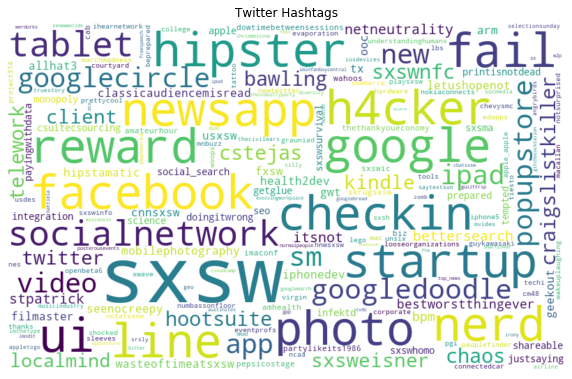

In [40]:
#  WordCloud for Hashtags
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,  background_color="white").generate(" ".join(set(hashtags)))
plt.figure(figsize=(10, 7))
plt.title('Twitter Hashtags')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

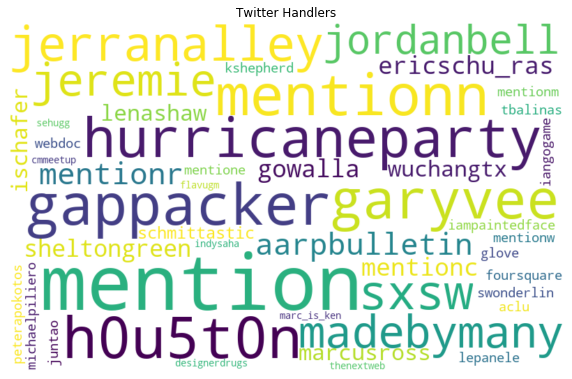

In [41]:
#  WordCloud for Twitter Handlers
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,  background_color="white").generate(" ".join(set(handlers)))
plt.figure(figsize=(10, 7))
plt.title('Twitter Handlers')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Text(0, 0.5, 'frequency')

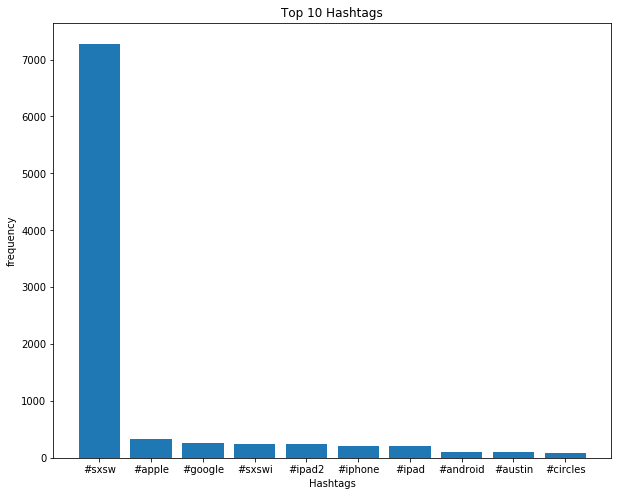

In [42]:
# Displaying frequently used Hashtags 
top_10_hashtags = dict(pd.Series(hashtags).value_counts()[:10])
plt.figure(figsize=(10,8))
plt.bar(top_10_hashtags.keys(),top_10_hashtags.values())
plt.title('Top 10 Hashtags')
plt.xlabel('Hashtags')
plt.ylabel('frequency')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

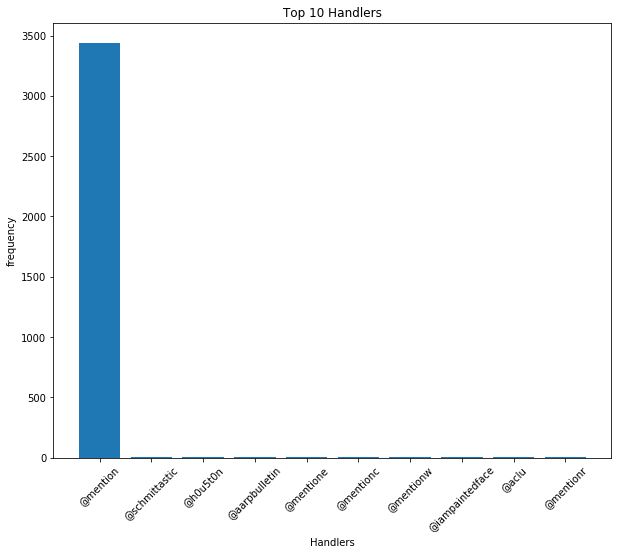

In [43]:
# Displaying frequently used Handlers 
top_10_handlers = dict(pd.Series(handlers).value_counts()[:10])
plt.figure(figsize=(10,8))
plt.bar(top_10_handlers.keys(),top_10_handlers.values())
plt.title('Top 10 Handlers')
plt.xlabel('Handlers')
plt.ylabel('frequency')
plt.xticks(rotation= 45)

### **Actual and Invalid links from Tweets**

In [0]:
#  Find Links from tweets
actual_links = []
Invalid_links = []
for tweet in tweets['tweet']:
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', tweet)
    for url in urls:
        try:
            res = urllib.request.urlopen(url)
            actual_url = res.geturl()
            actual_links.append(actual_url)
        except:
            Invalid_links.append(url)

In [45]:
#  Extract Title from actual links
links = []
title = []
for link in actual_links:
  html = urllib.request.urlopen(link)
  soup = BeautifulSoup(html,'lxml')
  title_text = soup.title
  if title_text:
    links.append(link)
    title.append(title_text.get_text())
  
df1 = pd.DataFrame()
df1['Links'] = links
df1['title'] = title
df1

,Links,title
0,http://twitpic.com/48j12p,Pics from the #apple #ipad2 line at #SXSW #fb
1,https://www.intech-bb.com/,Tech Inside - Tech for an ease
2,https://enterprise.foursquare.com/intersections/,Foursquare Intersections Blog
3,https://calendar.google.com/calendar/embed?src...,@hamsandwich SXSWi Calendar
4,https://www.tumblr.com/login_required/timkro/3...,Tumblr
5,https://www.facebook.com/events/141164002609303/,Facebook
6,https://www.forbes.com/sites/billbarol/2011/03...,Holler Gram is here
7,https://thenextweb.com/eu/2011/03/04/increasin...,Increasing Attendee Interaction with the 'Holl...
8,https://www.facebook.com/events/141164002609303/,Facebook
9,https://sites.google.com/site/frontgatesxsw11/,5th Annual Morning After Party


### **Finding Happy and Sad Emoticons**

In [0]:
#HappyEmoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])

# SadEmoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

In [0]:
#  Happy and Sad Emoticons list
Happy_Smiley = []
temp_tweets = []
Sad_Smiley = []
for i,tweet in enumerate(tweets.tweet):
  for smiley in emoticons_happy:
    for word in tweet.split():
      if smiley == word:
        temp_tweets.append(1)
        Happy_Smiley.append(smiley)
  for smiley in emoticons_sad:
    for word in tweet.split():
      if smiley == word:
        temp_tweets.append(0)
        Sad_Smiley.append(smiley)


In [48]:
#  Finding Happy and Sad Ratio
happy = [x for x in temp_tweets if x == 1 ]
sad = [x for x in temp_tweets if x == 0 ]
print(f"Total number of Happy Tweets= {len(happy)}")
print(f"Happy Ratio : {len(happy)/len(temp_tweets)}")
print()
print(f"Total number of Sad Tweets= {len(sad)}")
print(f"Sad Ratio : {len(sad)/len(temp_tweets)}")

Total number of Happy Tweets= 150
Happy Ratio : 0.8670520231213873

Total number of Sad Tweets= 23
Sad Ratio : 0.1329479768786127


Text(0.5, 1.0, 'Happy Emoticons count')

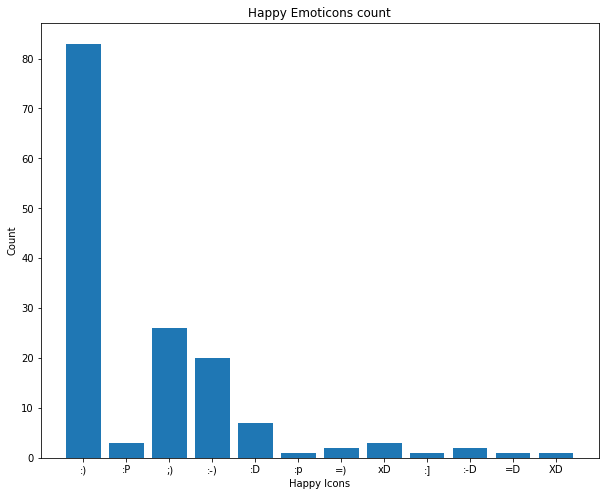

In [49]:
Happy_Icons = {x:Happy_Smiley.count(x) for x in Happy_Smiley}
plt.figure(figsize=(10,8))
plt.bar(Happy_Icons.keys(),Happy_Icons.values())
plt.xlabel('Happy Icons')
plt.ylabel('Count')
plt.title('Happy Emoticons count')

Text(0.5, 1.0, 'Sad Emoticons count')

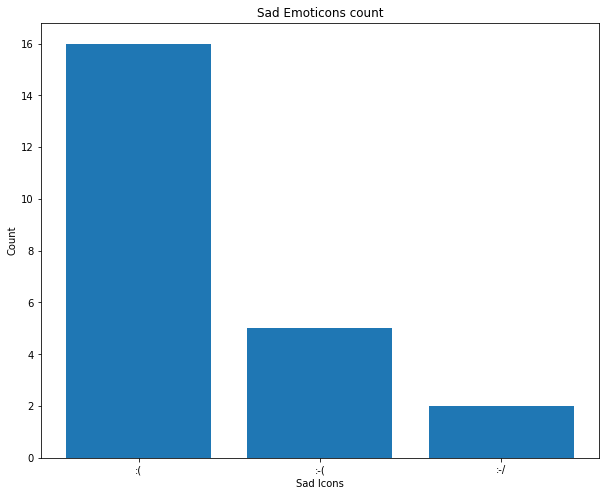

In [50]:
Sad_Icons = {x:Sad_Smiley.count(x) for x in Sad_Smiley}
plt.figure(figsize=(10,8))
plt.bar(Sad_Icons.keys(),Sad_Icons.values())
plt.xlabel('Sad Icons')
plt.ylabel('Count')
plt.title('Sad Emoticons count')

### **Data Pre-Processing**

In [0]:
newStopWords = ['rt','mention','link','video','cont','in','get','via']
stop_words.extend(newStopWords)


In [0]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

def preprocess(dataframe):
    dataframe['cleaned'] = dataframe['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))
    dataframe['cleaned'] = dataframe['cleaned'].str.replace('(\w+:\/\/\S+)|^rt|http.+?|[^\w\s]','')
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "@[\w]*")
    dataframe['cleaned'] = np.vectorize(remove_pattern)(dataframe['cleaned'], "\d*")
    

    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: nltk.word_tokenize(row))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in stop_words])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda row: [word for word in row if word not in string.punctuation])

    lemmatizer = WordNetLemmatizer()
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join(x))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x:unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore'))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([re.sub(r"[\d+\_\W+]",'',w) for w in x.split()]))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if not w.isdigit()]))
    dataframe['cleaned'] = dataframe['cleaned'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))
    return dataframe

In [0]:
cleaned_tweets = preprocess(tweets)

In [89]:
cleaned_tweets['sentiments'] = train_data['sentiment']
cleaned_tweets.sample(5)

,tweet,is_retweet,retweeted,mentioned,hashtags,cleaned,sentiments,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop
1181,I found this 'Emily White: On #SXSW' in the Mu...,False,[],[],[#SXSW],found emily white sxsw music business iphone app,1,6,15,15,80,12,3
5086,I won't lie - I've had a chance to watch peopl...,False,[],[],[#sxsw],wont lie ive chance watch people actually usin...,2,8,24,24,110,15,9
4847,Designing iPad Interfaces - New Navigation Sch...,False,[],[],"[#SXSW, #UXDes]",designing ipad interface new navigation schema...,1,4,9,9,65,9,0
3591,RT @mention Surprise! Apple opened a pop-up st...,True,[@mention],[],"[#SXSW, #cnet]",surprise apple opened popup store austin nerd ...,1,8,24,23,127,15,9
2054,Google Hotpot activity map for this week in Au...,False,[],[],"[#SxSW, #SUxSW]",google hotpot activity map week austin sxsw suxsw,1,5,14,14,81,10,4


### **Top words in the Tweets**

In [0]:
def top_words(corpus):
  words = [word.lower().split() for word in cleaned_tweets['cleaned']]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(15),columns=['words', 'count'])
  return df1
df1 = top_words(cleaned_tweets['cleaned'])

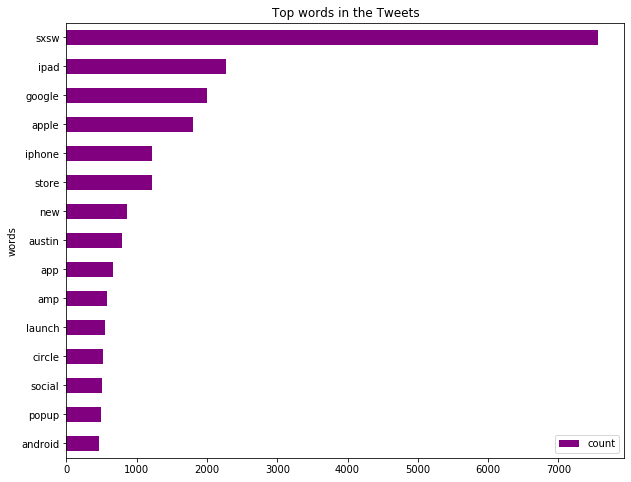

In [56]:
def plot_top_words(df1):
  fig, ax = plt.subplots(figsize=(10, 8))
  plt.title('Top words in the Tweets')
  df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")

plot_top_words(df1)

### **Bi-grams words**

In [0]:
# 0: Negative, 1: Neutral, 2: Positive, 3: Can't Tell
negative = cleaned_tweets[cleaned_tweets['sentiments']==0]
neutral = cleaned_tweets[cleaned_tweets['sentiments']==1]
positive = cleaned_tweets[cleaned_tweets['sentiments']==2]
cant_tell = cleaned_tweets[cleaned_tweets['sentiments']==3]


In [0]:
def Bigrams(corpus):
  words = [word.lower().split() for word in corpus]
  words = [list(bigrams(word)) for word in words]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
  return df1


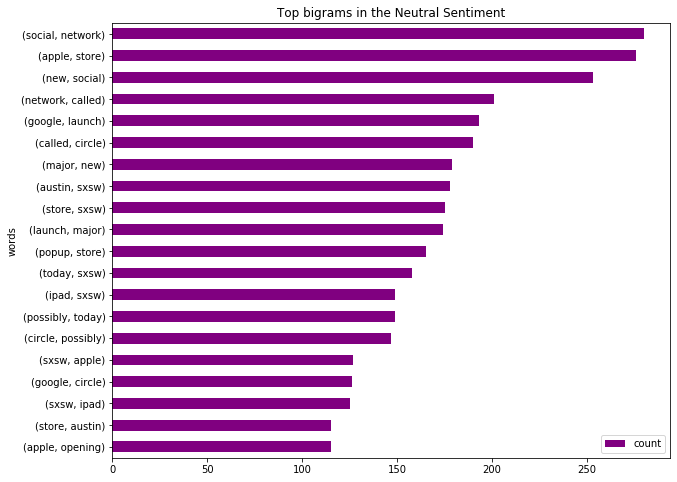

In [59]:
df1 = Bigrams(neutral['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top bigrams in the Neutral Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")


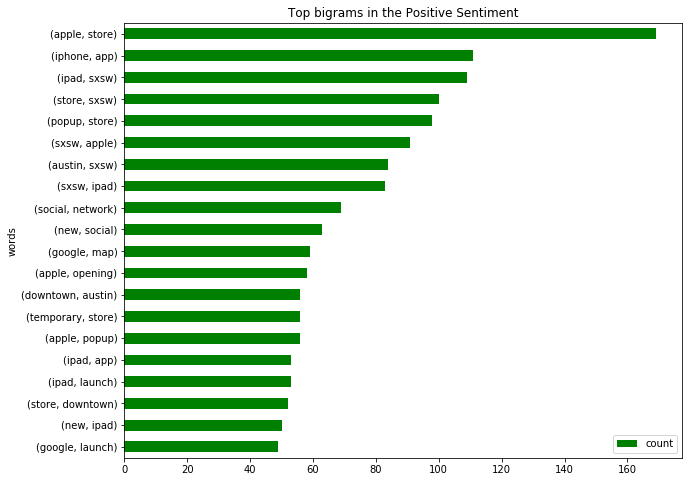

In [60]:
df1 = Bigrams(positive['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top bigrams in the Positive Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="green")

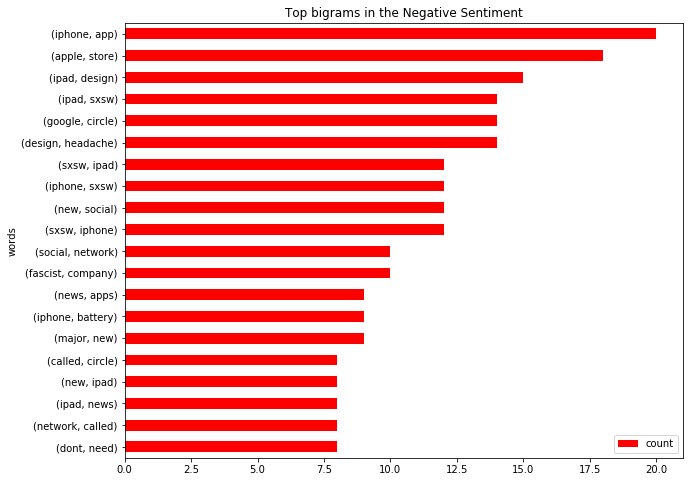

In [61]:
df1 = Bigrams(negative['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top bigrams in the Negative Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="red")

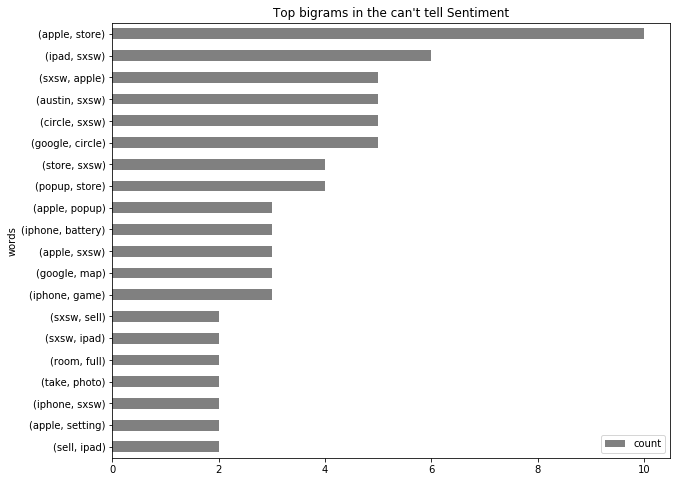

In [62]:
df1 = Bigrams(cant_tell['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top bigrams in the can\'t tell Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="grey")

### **Tri-grams words**

In [0]:
def Trigrams(corpus):
  words = [word.lower().split() for word in corpus]
  words = [list(trigrams(word)) for word in words]
  all_words = list(itertools.chain(*words))
  counts = collections.Counter(all_words)
  df1 = pd.DataFrame(counts.most_common(20),columns=['words', 'count'])
  return df1


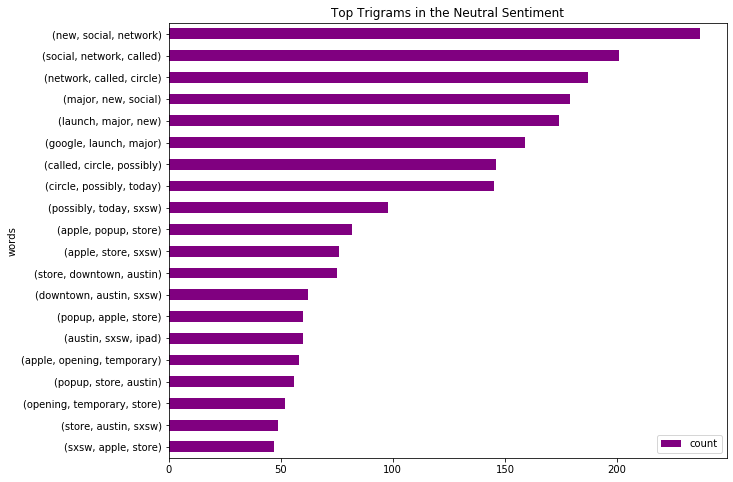

In [64]:
df1 = Trigrams(neutral['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top Trigrams in the Neutral Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")


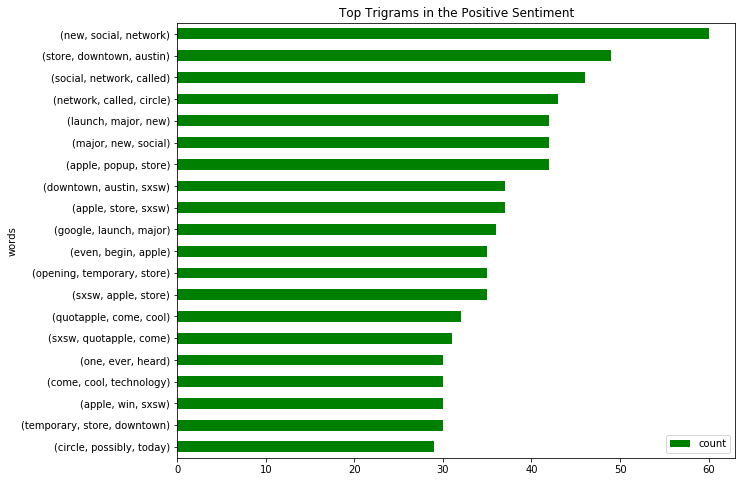

In [65]:
df1 = Trigrams(positive['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top Trigrams in the Positive Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="green")

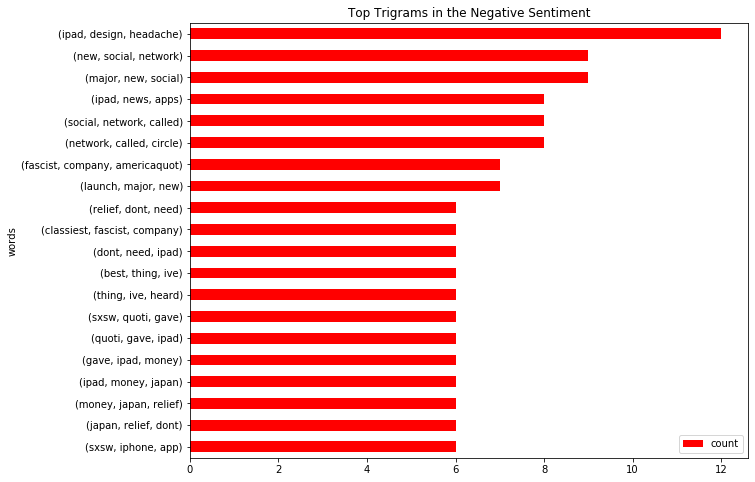

In [66]:
df1 = Trigrams(negative['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top Trigrams in the Negative Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="red")

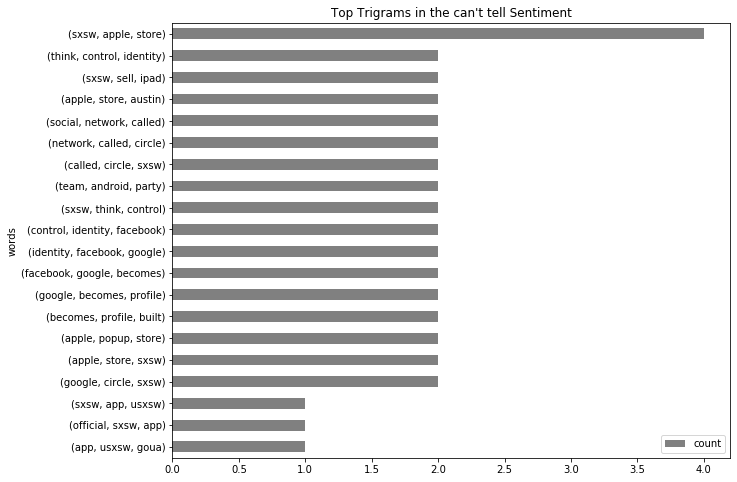

In [67]:
df1 = Trigrams(cant_tell['cleaned'])
fig, ax = plt.subplots(figsize=(10, 8))
plt.title('Top Trigrams in the can\'t tell Sentiment')
df1.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="grey")

### **Feature Engineering**

In [0]:
punctuation = string.punctuation
def feature_engineering(dataframe):
  df = dataframe
  
  # number of punctuations
  df['num_punc'] = df['tweet'].apply(lambda tweet_msg: len([punct for punct in tweet_msg if punct in punctuation]))

  # Finding the number of words in the headline
  df['num_words'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg.split()))

  # the unique number of words in the headline
  df['num_unique_words'] = df['tweet'].apply(lambda tweet_msg: len(set(tweet_msg.split())))

  # the number of characters in the headline
  df['num_chars'] = df['tweet'].apply(lambda tweet_msg: len(tweet_msg))

  # number of genuine words with no stopwords  
  df['num_words_nostop'] = df['tweet'].apply(lambda tweet_msg: len([word for word in tweet_msg.split() if word not in stop_words]))

  # number of stopwords
  df['num_stop'] = df['num_words'] - df['num_words_nostop']
  
  return df


In [69]:
tweets = feature_engineering(tweets)
tweets.head(3)

,tweet,is_retweet,retweeted,mentioned,hashtags,cleaned,sentiments,num_punc,num_words,num_unique_words,num_chars,num_words_nostop,num_stop
0,#sxswnui #sxsw #apple defining language of tou...,False,[],[],"[#sxswnui, #sxsw, #apple]",sxswnui sxsw apple defining language touch dif...,1,3,12,12,89,10,2
1,Learning ab Google doodles! All doodles should...,False,[],[],"[#GoogleDoodle, #sxsw]",learning google doodle doodle light funny amp ...,1,8,19,19,143,15,4
2,one of the most in-your-face ex. of stealing t...,False,[@mention],[],[#SXSW],one inyourface stealing show quotat sxsw apple...,2,12,22,19,132,15,7


### **Topic Modelling** 

In [0]:
train_tweets = cleaned_tweets['cleaned']

In [0]:
cleaned_test = preprocess(test_data)
test_tweets = cleaned_test['cleaned']

In [0]:
combi_tweets = pd.concat([train_tweets,test_tweets], ignore_index=True)
# combi_tweets = pd.DataFrame(combi_tweets, columns=['tweets'])

**LSA**

In [0]:
tfidf = TfidfVectorizer(stop_words='english')

In [0]:
X = tfidf.fit_transform(combi_tweets)

In [0]:
train, test = X[:7274,:],X[7274:,:]

In [76]:
train.shape

(7274, 9252)

In [0]:
from sklearn.decomposition import TruncatedSVD
from pprint import pprint

In [0]:
svd = TruncatedSVD(n_components=15,n_iter=100)

In [79]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=15, n_iter=100,
             random_state=None, tol=0.0)

In [80]:
svd.components_

array([[ 1.73945757e-04,  2.32389678e-03,  9.40263361e-05, ...,
         1.98479193e-04,  4.72253673e-04,  4.00360423e-05],
       [ 3.30495627e-04,  4.01592279e-03,  9.86055938e-05, ...,
         2.31600247e-05,  2.74779586e-04,  3.37862376e-05],
       [-2.87924361e-04, -1.75845070e-03,  6.24066810e-04, ...,
         4.89564420e-04,  7.45366150e-04,  4.22721678e-04],
       ...,
       [ 9.12268783e-04, -4.46418578e-03,  3.73129775e-04, ...,
         9.30509064e-05,  2.13333290e-03,  1.24145478e-04],
       [ 1.87162503e-04, -1.24427444e-05,  5.53313755e-05, ...,
        -1.37042226e-04, -1.19875838e-03, -7.96238586e-05],
       [ 1.06745430e-04,  1.51093412e-03,  6.76369226e-04, ...,
         3.65739343e-05,  1.66327653e-03,  6.35111618e-04]])

In [0]:
terms = tfidf.get_feature_names()

In [82]:
for i,comp in enumerate(svd.components_):
  terms_comp = zip(terms,comp)
  sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
  pprint("Topic "+str(i)+": ")
  pprint(sorted_terms)
  


'Topic 0: '
[('launch', 0.2903707459334132),
 ('circle', 0.28308897101312414),
 ('sxsw', 0.2812035775342502),
 ('social', 0.2760605581613767),
 ('network', 0.2685438874747762),
 ('google', 0.26722802780813537),
 ('apple', 0.2580107691237623),
 ('new', 0.25511493491075865),
 ('store', 0.23743426765255415),
 ('called', 0.23274676338984832)]
'Topic 1: '
[('apple', 0.4283739023327453),
 ('store', 0.3872552907182354),
 ('ipad', 0.26412526749100035),
 ('austin', 0.2258525096084319),
 ('popup', 0.22145448646846635),
 ('sxsw', 0.17452650407938464),
 ('opening', 0.15513453008064207),
 ('temporary', 0.14008398385841564),
 ('line', 0.1254045300569716),
 ('downtown', 0.12505380668228067)]
'Topic 2: '
[('iphone', 0.3479172815220614),
 ('sxsw', 0.34304828875777627),
 ('app', 0.28677812303851347),
 ('ipad', 0.2434595021608947),
 ('google', 0.22763134284350742),
 ('android', 0.18194587238822602),
 ('mobile', 0.16437973764757943),
 ('amp', 0.14116718040524273),
 ('map', 0.11817015075773517),
 ('free', 

Topic: 0


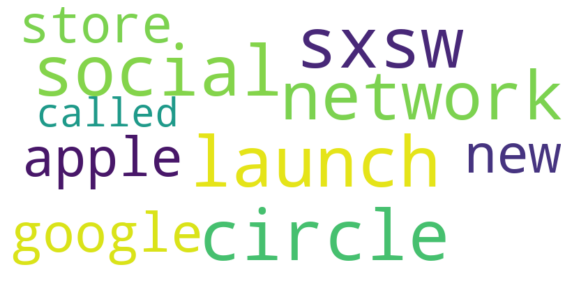

Topic: 1


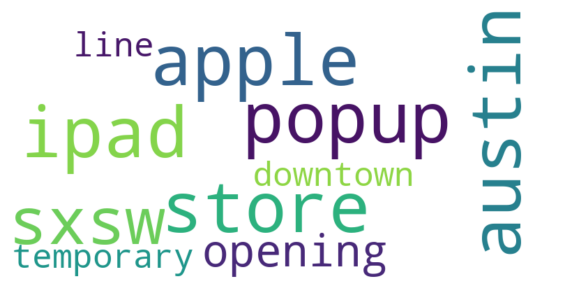

Topic: 2


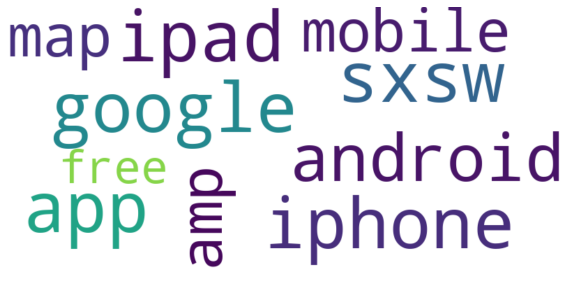

Topic: 3


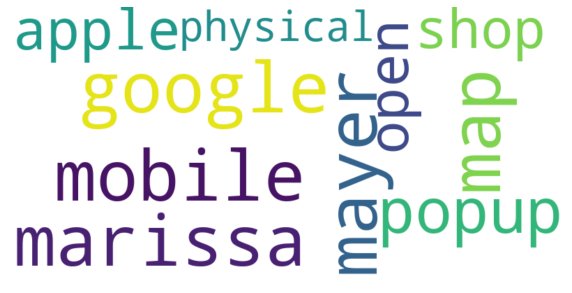

Topic: 4


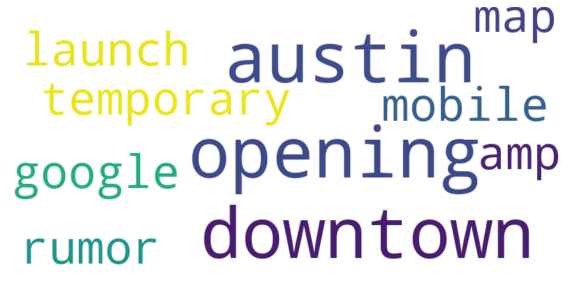

Topic: 5


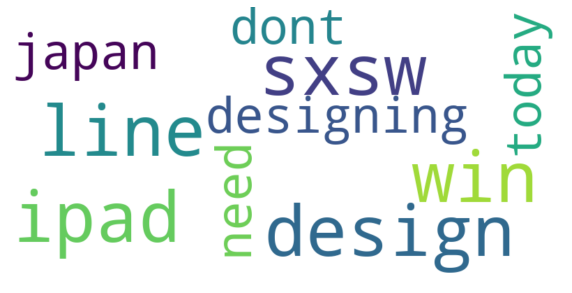

Topic: 6


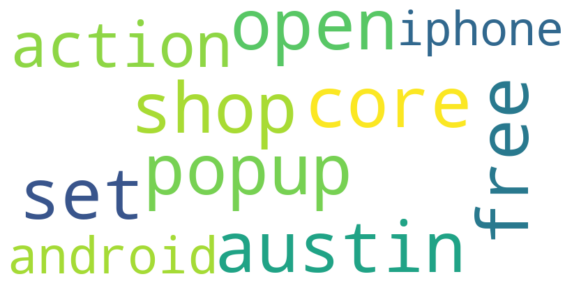

Topic: 7


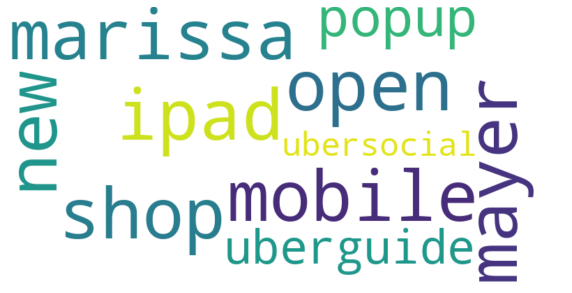

Topic: 8


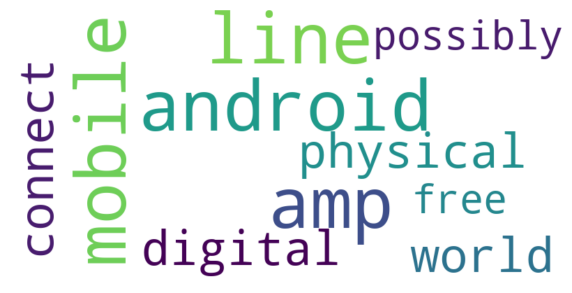

Topic: 9


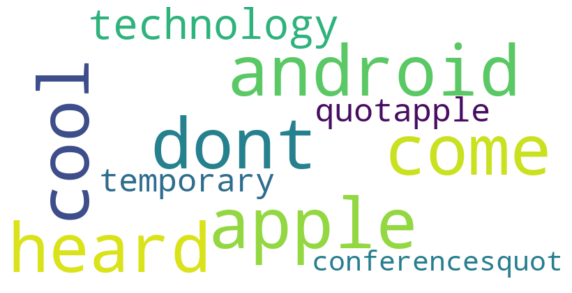

Topic: 10


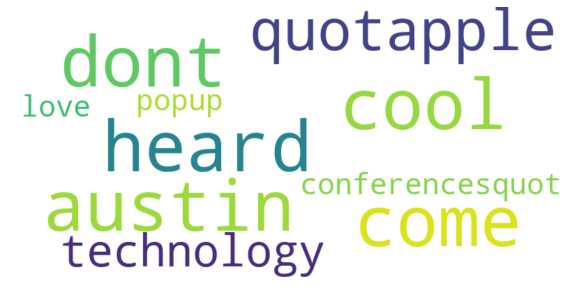

Topic: 11


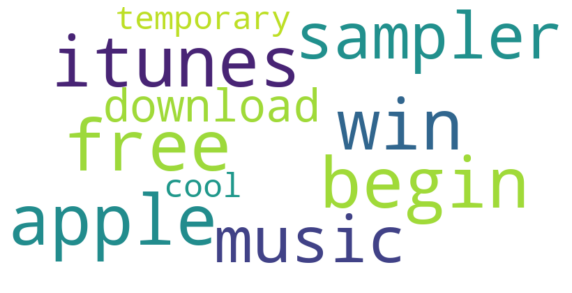

Topic: 12


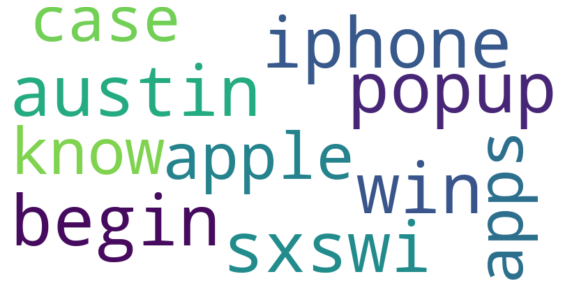

Topic: 13


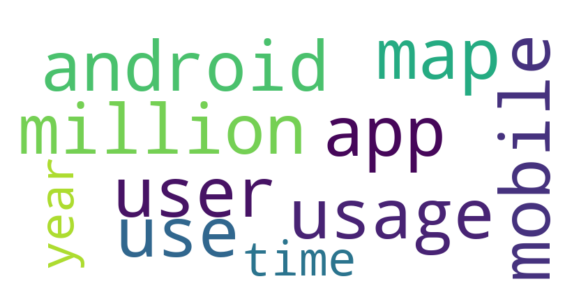

Topic: 14


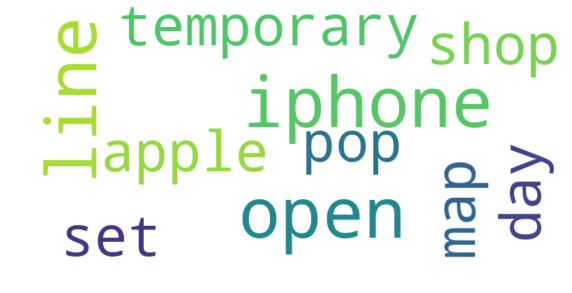

In [83]:
wordcloud = WordCloud(background_color='white',
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)
  
for i,comp in enumerate(svd.components_):
  terms_comp = zip(terms,comp)
  sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
  print(f"Topic: {i}")
  res = [lis[0] for lis in sorted_terms]
  wordcloud.generate(" ".join(res))
  plt.figure(figsize=(10, 7))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis('off')
  plt.show()

**LDA**

In [0]:
words = [word_tokenize(text) for text in combi_tweets]

In [0]:
dictionary = corpora.Dictionary(words)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in words]


In [86]:
lda = LdaModel(corpus=doc_term_matrix,num_topics=15,id2word=dictionary,passes=100)
pprint(lda.print_topics(num_topics=15,num_words=10))

KeyboardInterrupt: ignored

### **Save TFIDF matrix**

In [0]:
# type(test)

In [0]:
train_tfidf = pd.DataFrame(train.toarray(), columns=tfidf.get_feature_names())
train_tfidf['senitment'] = train_data['sentiment']
test_tfidf = pd.DataFrame(test.toarray(), columns=tfidf.get_feature_names())

In [0]:
train_tfidf.to_pickle('/content/drive/My Drive/Sentiment Analysis hackathon/train_tfidf.pkl')
test_tfidf.to_pickle('/content/drive/My Drive/Sentiment Analysis hackathon/test_tfidf.pkl')